In [1]:
!pip install lightgbm shap scikit-learn seaborn matplotlib --quiet

In [166]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import shap


In [206]:
# Load the dataset
df = pd.read_csv(r"C:\Users\USER\Chameleon AI-IoT\MOP-Code\artificial-intelligence\CyberSecurity\datasets\HITECH_Cleaned.csv")
df.head()


,name_of_covered_entity,state,covered_entity_type,individuals_affected,breach_submission_date,type_of_breach,location_of_breached_information,business_associate_present,web_description,breach_year,breach_month,severity_level,type_of_breach_encoded,location_of_breached_information_encoded,covered_entity_type_encoded
0,William F Rinehart DMD PA,SC,Healthcare Provider,25000.0,2025-03-24,Hacking/IT Incident,Network Server,No,No description provided,2025,3,High,0,83,3
1,Meigs County Emergency Medical Services,OH,Healthcare Provider,5802.0,2025-03-20,Hacking/IT Incident,Email,No,No description provided,2025,3,Moderate,0,66,3
2,Presbyterian Health Plan,NM,Health Plan,7100.0,2025-03-18,Hacking/IT Incident,Email,No,No description provided,2025,3,Moderate,0,66,1
3,Baylor Scott & White Texas Spine & Joint Hospital,TX,Healthcare Provider,1640.0,2025-03-14,Hacking/IT Incident,Email,No,No description provided,2025,3,Moderate,0,66,3
4,Lake Psychological Services,PA,Healthcare Provider,987.0,2025-03-14,Hacking/IT Incident,Network Server,No,No description provided,2025,3,Low,0,83,3


severity_level
Moderate    3167
High        1608
Low         1360
Critical     650
Name: count, dtype: int64


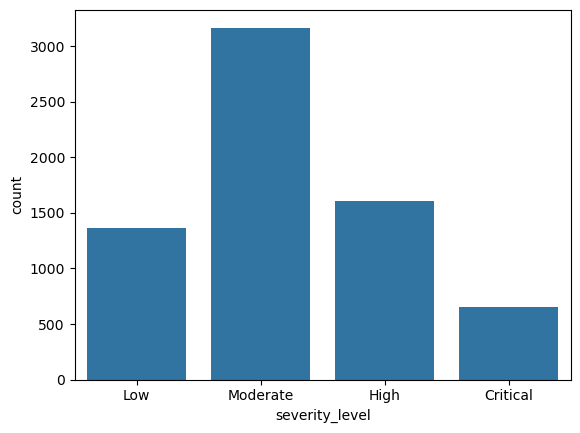

In [170]:
print(df['severity_level'].value_counts(dropna=False))
sns.countplot(data=df, x='severity_level', order=['Low','Moderate','High','Critical'])
plt.show()

In [182]:
target   = 'severity_level'

# Categorical columns (already label‑encoded in HITECH_Cleaned.csv)
cat_cols = [
    'type_of_breach_encoded',
    'location_of_breached_information_encoded',
    'covered_entity_type_encoded',
    'state'  
]

# Numeric columns
num_cols = [
    'individuals_affected',
    'breach_year',
    'breach_month'
]

X = df[cat_cols + num_cols].copy()
y = df[target]
# Log-transform target for regression
df['log_individuals_affected'] = np.log10(df['individuals_affected'] + 1)

# Cast string categorical to category dtype
X['state'] = X['state'].astype('category')
df['severity_level'] = pd.Categorical(df['severity_level'], categories=['Low', 'Moderate', 'High', 'Critical']).codes


In [184]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (5088, 7) Test shape: (1697, 7)


In [186]:
lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols, free_raw_data=False)
lgb_test  = lgb.Dataset(X_test,  label=y_test,  categorical_feature=cat_cols, free_raw_data=False)


In [188]:
params = {
    'objective'        : 'multiclass',
    'num_class'        : 4,
    'metric'           : 'multi_logloss',
    'learning_rate'    : 0.05,
    'num_leaves'       : 31,
    'feature_fraction' : 0.8,
    'bagging_fraction' : 0.8,
    'bagging_freq'     : 5,
    'seed'             : 42,
    'verbose'          : -1
}


In [190]:
from lightgbm import early_stopping, log_evaluation

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_test],
    callbacks=[
        early_stopping(stopping_rounds=50),  
        log_evaluation(period=100)            
    ]
)


Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.00461361	valid_1's multi_logloss: 0.0106472
Early stopping, best iteration is:
[110]	training's multi_logloss: 0.00322718	valid_1's multi_logloss: 0.00999076



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       163
           1       0.99      0.99      0.99       402
           2       1.00      1.00      1.00       340
           3       0.99      1.00      1.00       792

    accuracy                           1.00      1697
   macro avg       1.00      0.99      1.00      1697
weighted avg       1.00      1.00      1.00      1697



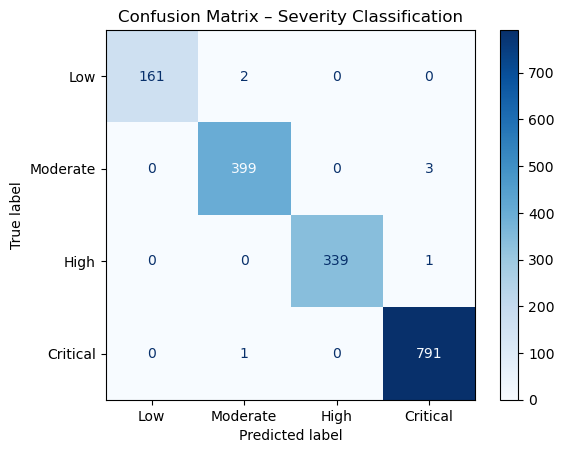

In [192]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(cm, display_labels=['Low','Moderate','High','Critical'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix – Severity Classification")
plt.show()


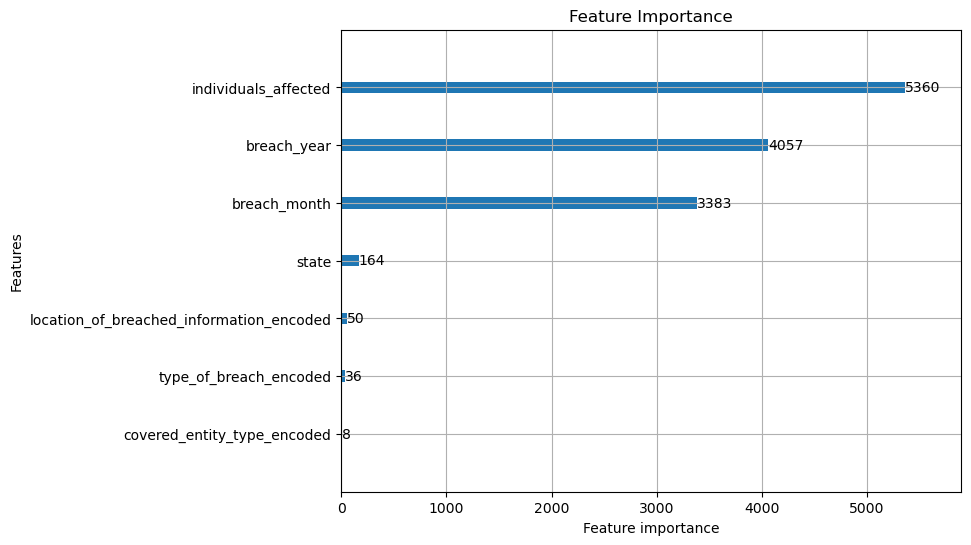

In [194]:
lgb.plot_importance(model, max_num_features=7, figsize=(8,6))
plt.title("Feature Importance")
plt.show()


In [198]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap_values.shape


(1697, 7, 4)


SHAP summary for severity level: Low


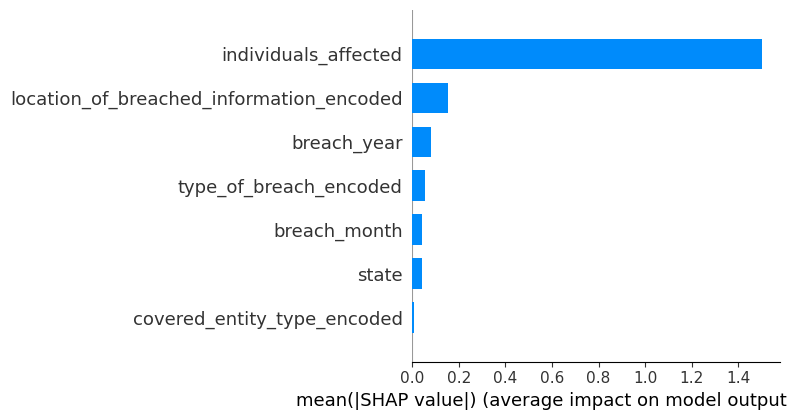


SHAP summary for severity level: Moderate


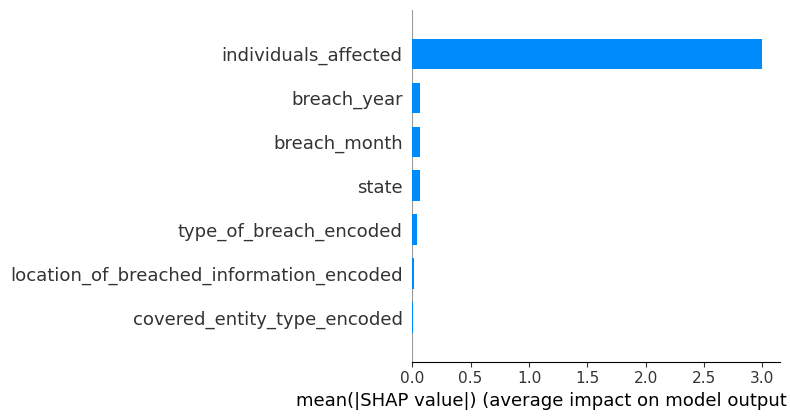


SHAP summary for severity level: High


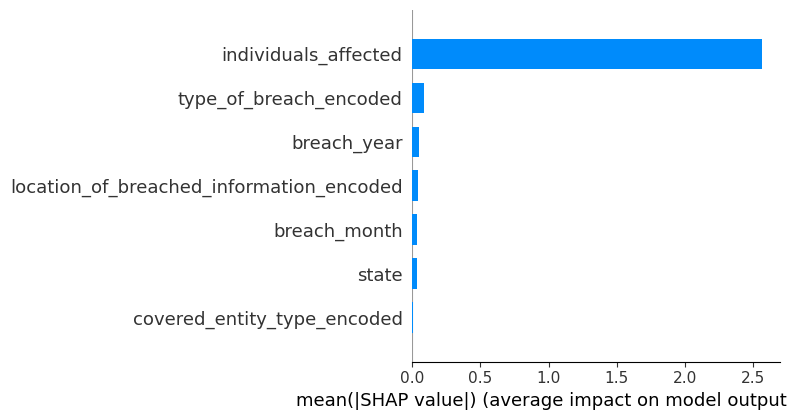


SHAP summary for severity level: Critical


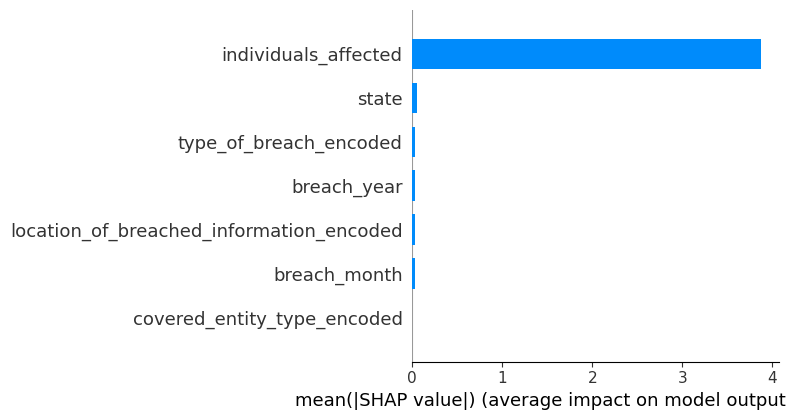

In [199]:
class_labels = ['Low', 'Moderate', 'High', 'Critical']

for i, label in enumerate(class_labels):
    print(f"\nSHAP summary for severity level: {label}")
    shap.summary_plot(shap_values[:, :, i], X_test, plot_type="bar")


In [202]:
X_reg = X.copy()
y_reg = df['log_individuals_affected']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

reg_model = lgb.LGBMRegressor()
reg_model.fit(X_train_r, y_train_r)

print("R²:", reg_model.score(X_test_r, y_test_r))

R²: 0.9994859753877126


In [204]:
import joblib
joblib.dump(model, "severity_model_lgb.pkl")
joblib.dump(reg_model, "severity_regression_model.pkl")


['severity_regression_model.pkl']